In [1]:
# source:https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

# Dataset

In [2]:
import pandas as pd
import pickle


df = pd.read_pickle(r'C:\Users\Feli\Documents\NTHU\DataMining\DMLab2\DM19-Lab2-Master\data_porter.pkl')
df.head()

,tweet_id,text,hashtags,identification,emotion,text_prep
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat],train,anticipation,snapchat peopl post add snapchat must dehydr c...
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]",train,sadness,freepress trumplegaci cnn brianklaa see trump ...
2,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse],test,NaN,biblevers confid obedi write know even ask phi...
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[],train,fear,issa stalk tasha 😂😂😂 lh
4,0x2de201,"""Trust is not the same as faith. A friend is s...",[],test,NaN,trust faith friend someon trust put faith anyo...


In [3]:
import numpy as np 
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))


Using TensorFlow backend.
c:\users\feli\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\feli\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\feli\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [5]:
# create dataset for training
df_train = df[df['identification'] == "train"]
df_train = df_train[df_train.emotion.isnull()==False]
df_train.reset_index(drop=True,inplace=True)
df_train = df_train.sample(frac=1)

In [6]:
data = df_train[['emotion', 'text']]

data.head()

,emotion,text
990718,anticipation,@dak good win...u know what U need 2 do to get...
1422827,trust,Blessing just keep pouring down right now litt...
386007,disgust,"@JohnFugelsang You CAN'T fix #Stupid, but you ..."
534164,disgust,@thehill Why does he need protection!? I thoug...
1054333,disgust,What is a 'white nationalist' anyway? Let's ca...


# Model

In [7]:
from keras.preprocessing.text import Tokenizer

# the maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) 
tokenizer.fit_on_texts(data.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 912661 unique tokens.


In [8]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1455563, 250)


In [9]:
import keras
from sklearn.preprocessing import LabelEncoder

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

label_encoder = LabelEncoder()
label_encoder.fit(data['emotion'])

Y = label_encode(label_encoder, data['emotion'])


print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1455563, 8)


In [12]:
# create model

from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total params: 5,081,208
Trainable params: 5,081,208
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# train model

epochs = 3
batch_size = 64

history = model.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1310006 samples, validate on 145557 samples
Epoch 1/3
1310006/1310006 [==============================] - 14417s 11ms/step - loss: 1.2132 - acc: 0.5639 - val_loss: 1.1150 - val_acc: 0.5983
Epoch 2/3
1310006/1310006 [==============================] - 10671s 8ms/step - loss: 1.0814 - acc: 0.6110 - val_loss: 1.0884 - val_acc: 0.6086
Epoch 3/3
1310006/1310006 [==============================] - 10690s 8ms/step - loss: 1.0307 - acc: 0.6299 - val_loss: 1.0867 - val_acc: 0.6109


# Analyse Output

In [14]:
# this model was trained with all the data to archieve a better model
# in a former version, test and training data where used and created according to the following code:

# this line has to be inserted before the model training and then X_train and Y_train should be used for the model training
#X_train, X_test, y_train, y_test = train_test_split(data.text_prep, data.emotion, test_size=0.33, random_state=42)

#y_train_eval = y_train
#y_test_eval = y_test

In [15]:
# before, the accuracy was computed through the testing data:
#accr = model.evaluate(X_test,Y_test)
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

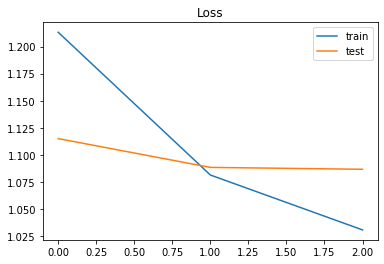

In [16]:

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

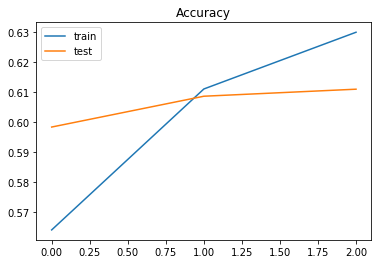

In [17]:

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [18]:
model_json = model.to_json()
with open('model_36.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model_36.h5')

# Create submission file 

In [19]:
df_submission = df[df['identification'] == "test"]

x_submission = tokenizer.texts_to_sequences(df_submission['text'].values)
x_submission = pad_sequences(x_submission, maxlen=MAX_SEQUENCE_LENGTH)

y_pred_submission = model.predict(x_submission)

In [20]:
y_pred_submission1 = label_decode(label_encoder, y_pred_submission)
y_pred_submission1

array(['anticipation', 'anticipation', 'joy', ..., 'sadness', 'anger',
       'sadness'], dtype=object)

In [21]:
df_submission["pred_result"] = y_pred_submission1
df_submission.head()

c:\users\feli\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tweet_id,text,hashtags,identification,emotion,text_prep,pred_result
2,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse],test,NaN,biblevers confid obedi write know even ask phi...,anticipation
4,0x2de201,"""Trust is not the same as faith. A friend is s...",[],test,NaN,trust faith friend someon trust put faith anyo...,anticipation
9,0x218443,When do you have enough ? When are you satisfi...,"[materialism, money, possessions]",test,NaN,materi money possess enough satisfi goal reall...,joy
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...","[GodsPlan, GodsWork]",test,NaN,godsplan godswork god woke chase day godsplan ...,joy
33,0x26289a,"In these tough times, who do YOU turn to as yo...",[],test,NaN,tough time turn symbol hope lh,trust


In [22]:
df_sub_final=df_submission[["tweet_id","pred_result"]]
df_sub_final.reset_index(drop=True,inplace=True)

df_sub_final = df_sub_final.rename(columns = {"tweet_id": "id", 
                                  "pred_result": "emotion"})

df_sub_final.head()

,id,emotion
0,0x28b412,anticipation
1,0x2de201,anticipation
2,0x218443,joy
3,0x2939d5,joy
4,0x26289a,trust


In [23]:
df_sub_final.to_csv(r'C:\Users\Feli\Documents\NTHU\DataMining\DMLab2\DM19-Lab2-Master\Model_36.csv',index=False)

# Histogram of predicted outputs

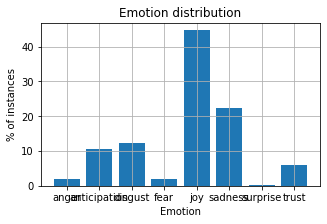

In [24]:
# the histogram of the data

import matplotlib.pyplot as plt

labels = df_sub_final['emotion'].unique()
post_total = len(df_sub_final)
df1 = df_sub_final.groupby(['emotion']).count()['id']
df1 = df1.apply(lambda x: round(x*100/post_total,3))


#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()